Import libraries

In [1]:
import numpy as np
import xarray as xr
import cf_xarray
from xgcm import Grid, generate_grid_ds
import gsw_xarray as gsw

import numpy as np
import xarray as xr
import cf_xarray
import neutralocean
import neutralocean.grid.rectilinear
import neutralocean.ntp

from xgcm import Grid
import gsw_xarray as gsw

import matplotlib.pyplot as plt

import xarray as xr
import cf_xarray
import numpy as np
import jax
from jax import numpy as jnp
import optax
import matplotlib.pyplot as plt

## At first, we process dataset to add, SA, CT, etc

Open WOA23 dataset

In [2]:
ds = xr.open_mfdataset(
    "../data/woa23*.nc", decode_times=False
).squeeze("time", drop=True)[["t_an","s_an"]]
# We only keep the objectively analyzed mean fields
ds = ds.assign_coords({"lon":ds.lon%360}).sortby("lon")
ds.lon.attrs["standard_name"] = "longitude"

In [3]:
ds["p"] = gsw.p_from_z(z=-ds["depth"], lat=ds.lat)

In [4]:
# add CT and SA
ds["SA"] = ds.gsw.SA_from_SP()

In [5]:
ds["CT"] = ds.gsw.CT_from_t()

### Create xgcm.Grid

For this, we need to create some new dimensions

1. Create new dims: lon/lat/depth to x_c, y_c, z_c
1. Create new x_f, y_f, z_f dimensions that correspond to cell faces and add proper attributes
2. Add metrics
3. Create final grid

In [6]:
ds = generate_grid_ds(
    ds,
    {"X":ds.cf["longitude"].name, "Y":ds.cf["latitude"].name, "Z":ds.cf["depth"].name},
    position={'X':('center','right'),'Y':('center','right'),'Z':('center','right')}
)

In [7]:
for xyz, lld in zip(["x","y","z"],["longitude","latitude","depth"]):
    ds[f"{xyz}_c"] = (ds.cf[lld].name, np.arange(ds.cf[lld].shape[0]))
    ds = ds.swap_dims({ds.cf[lld].name:f"{xyz}_c"})
    ds[f"{xyz}_f"] = (ds.cf[lld].name+"_right", np.arange(ds.cf[lld].shape[0]))
    ds = ds.swap_dims({ds.cf[lld].name+"_right":f"{xyz}_f"})
    ds[f"{xyz}_c"].attrs["axis"] = ds[ds.cf[lld].name].attrs.pop("axis")
    ds[f"{xyz}_f"].attrs["axis"] = ds[ds.cf[lld].name+"_right"].attrs.pop("axis")
    ds[f"{xyz}_f"].attrs["c_grid_axis_shift"] = ds[ds.cf[lld].name+"_right"].attrs.pop("c_grid_axis_shift")
    ds[ds.cf[lld].name+"_right"].attrs["standard_name"] = lld

In [8]:
grid = Grid(ds, periodic=["X"])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> right
  * right    z_f --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center

In [9]:
dlong = 1
dlonc = 1

dlatg =1
dlatc = 1

In [10]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * np.cos(np.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

ds.coords['e1tu'], e2 = dll_dist(dlonc, dlatc, ds.lon, ds.lat)
# e1tu is at u and t points => function of y_c
ds.coords['e2'] = np.nanmean(e2)
ds.coords['e1vf'], e2 = dll_dist(dlonc, dlatc, ds.lon, ds.lat_right)
# e1vf is at v and f points => function of y_f

In [11]:
ds.coords["e3w"] = grid.diff(
    ds["depth"],
    "Z",
    boundary="fill",
    fill_value=2*ds["depth"].values[-1] - ds["depth"].values[-2]
)

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [12]:
ds.coords["e3t"] = grid.diff(
    ds["depth_right"],
    "Z",
    boundary="fill",
    fill_value=-ds["depth_right"].values[0]
)

### We recreate the xgcm.Grid with the new dataset

In [13]:
grid = Grid(ds, periodic=["X"], metrics={"X":["e1tu","e1vf"], "Y":["e2"], "Z":["e3t","e3w"]})
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> right
  * right    z_f --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center

In [14]:
# we transpose the dataset to get (x,y,z) order
ds = ds.transpose(
    "x_c", "x_f", "y_c", "y_f", "z_c", "z_f", ...
)

## Computing reference neutral slopes

The neutral slope is defined as:

$$
\vec{\nabla}_h z = - \frac{1}{\rho_0} \frac{g}{N^2} \vec{\epsilon_h}
$$

So we need to compute:

#### $N^2$ at U and V points

$$
N^2 = -\frac{g}{\rho} \frac{\partial \rho}{\partial z}
$$

$$
N^2 = g \left(\alpha \frac{\partial \Theta}{\partial z} 
- \beta \frac{\partial S_A}{\partial z} \right)
$$


#### $\vec{\epsilon_h}$ at U and V points

As we compute along iso-depth, the gradients along surface are horizontal gradients:

$$
\vec{\epsilon_h} = \vec{\nabla}_h \rho = \rho_S \vec{\nabla}_h S +  \rho_\Theta \vec{\nabla}_h \Theta
$$

We compute $\vec{\epsilon_h}$ using the in-situ density (we take the horizontal gradient so it is equivalent to using locally referenced potential density).




#### $\vec{\epsilon_h}$

In [15]:
rho = gsw.rho(
    ds.SA,
    ds.CT,
    ds.p,
)

In [16]:
ds["ey"] = grid.derivative(rho, "Y")
ds["ex"] = grid.derivative(rho, "X")

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


#### $N^2$

In [17]:
g = 9.7963
# https://teos-10.github.io/GSW-Python/_modules/gsw/stability.html#Nsquared

In [18]:
dCT_dz = -grid.derivative(ds.cf["sea_water_conservative_temperature"], "Z")
# minus sign as z increases downward

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [19]:
dSA_dz = -grid.derivative(ds.cf["sea_water_absolute_salinity"], "Z")
# minus sign as z increases downward

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [20]:
CT_w = grid.interp(ds.cf["sea_water_conservative_temperature"], "Z")
SA_w = grid.interp(ds.cf["sea_water_absolute_salinity"], "Z")

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [21]:
alpha = gsw.alpha(SA_w, CT_w, gsw.p_from_z(z=-ds.depth_right, lat=ds.lat))
beta = gsw.beta(SA_w, CT_w, gsw.p_from_z(z=-ds.depth_right, lat=ds.lat))

In [22]:
N2 = g * (alpha*dCT_dz - beta*dSA_dz)

In [23]:
ds["N2"] = N2

Remember what we want:


$$
\vec{\nabla}_h z = - \frac{1}{\rho_0} \frac{g}{N^2} \vec{\epsilon_h}
$$

So we interpolate $N^2$, $\Theta$, and $S_A$ at U and V point

In [24]:
ds["rho_0"] = 1026

In [25]:
ds["grad_h_z_U"] = - 1 / ds.rho_0 * g / grid.interp(
    ds.N2,
    ["X","Z"],
) * ds.ex

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [26]:
ds["grad_h_z_V"] = - 1 / ds.rho_0 * g / grid.interp(
    ds.N2,
    ["Y","Z"],
) * ds.ey

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


## Optimization of the surface

In [27]:
# We remove Arctic Ocean for simplicity

ds[[i for i in ds if "y_c" in ds[i].dims]] = ds[[i for i in ds if "y_c" in ds[i].dims]].where(ds.lat<65)
ds[[i for i in ds if "y_f" in ds[i].dims]] = ds[[i for i in ds if "y_f" in ds[i].dims]].where(ds.lat_right<65)

### Defining the cost function

we take the MSE of difference of gradients

In [28]:
# convert arrays of grad_h_z and depth into jax arrays

grad_h_z_U = jnp.asarray(ds.grad_h_z_U)
grad_h_z_V = jnp.asarray(ds.grad_h_z_V)
depth_U = jnp.asarray(ds.depth.broadcast_like(ds.grad_h_z_U))
depth_V = jnp.asarray(ds.depth.broadcast_like(ds.grad_h_z_V))

e1u = jnp.asarray(ds.e1tu)
e2v = jnp.asarray(ds.e2)

In [29]:
# define a function to interpolate neutral slopes (at U,V points)
# to the surface
interp_1d_at_every_point = jax.vmap(jax.vmap(jnp.interp, in_axes=0), in_axes=0)

In [30]:
def compute_slope_of_surface_along_axis(surface, axis, e):
    """
    surface : 2D arrays, shape (x,y)
    axis : axis on which to compute gradient, 0 for x, 1 for y
    e : scale factor
    """
    return (jnp.roll(surface, -1, axis) - surface) / e

In [31]:
# We define masks so the surface slopes are not NaNs at the boundaries

umask = jnp.where(
    jnp.isfinite(
        compute_slope_of_surface_along_axis((ds.SA.isel(z_c=0)*0+1).values, 0, 1.)
    ),
    1,
    0
)

vmask = jnp.where(
    jnp.isfinite(
        compute_slope_of_surface_along_axis((ds.SA.isel(z_c=0)*0+1).values, 1, 1.)
    ),
    1,
    0
)

In [32]:
def compute_neutral_slope_along_surface_x(surface):
    out = interp_1d_at_every_point(
        x=(jnp.roll(surface,-1,0) + surface)/2, # interpolated at U point
        xp=depth_U,
        fp=grad_h_z_U
    )
    return out

def compute_neutral_slope_along_surface_y(surface):
    out = interp_1d_at_every_point(
        x=(jnp.roll(surface,-1,1) + surface)/2, # interpolated at V point
        xp=depth_V,
        fp=grad_h_z_V
    )
    return out

In [33]:
def floss(surface):
    """Loss function"""
    grad_U = jnp.nan_to_num(
        compute_slope_of_surface_along_axis(surface, axis=0, e=e1u)
    )
    grad_V = jnp.nan_to_num(
        compute_slope_of_surface_along_axis(surface, axis=1, e=e2v)
    )
    neutral_slope_U = jnp.nan_to_num(
        compute_neutral_slope_along_surface_x(surface)
    )*0
    neutral_slope_V = jnp.nan_to_num(
        compute_neutral_slope_along_surface_y(surface)
    )*0
    # the last term is a regularization term, to fix the surface at a cast value
    return jnp.nansum(
        (grad_U - neutral_slope_U)**2 * umask + (grad_V - neutral_slope_V)**2 * vmask
    ) *1e6 + (surface[180,90])**2*0
    

### Optimization

In [34]:
grad_loss = jax.grad(floss)

def train(params, learning_rate=0.01, num_steps=1000):
    """Train using gradient descent optimization"""
    # Define optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    losses = []
    
    for step in range(num_steps):
        # Compute loss and gradients
        loss = floss(params)
        #grads = jnp.nan_to_num(grad_loss(params))
        grads = grad_loss(params)
        
        losses.append(loss)
        
        # Apply updates
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        # Print progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss}")
            plt.imshow(params.T)
            plt.show()
    
    return params, losses

In [35]:
# Test with a surface that has a constant slope
initial_surface = jnp.asarray((ds.lat+ds.SA.isel(z_c=0)*0).transpose("x_c","y_c").values)

In [36]:
floss(initial_surface)

Array(2.7690122, dtype=float32)

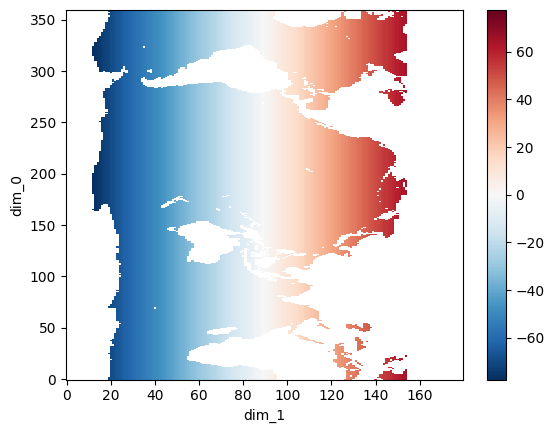

In [37]:
xr.DataArray(initial_surface).plot()

In [38]:
g = grad_loss(initial_surface)

In [39]:
ds["gradient"] = xr.DataArray(g, dims=("x_c", "y_c"))

In [40]:
initial_surface[180,90]

Array(0.5, dtype=float32)

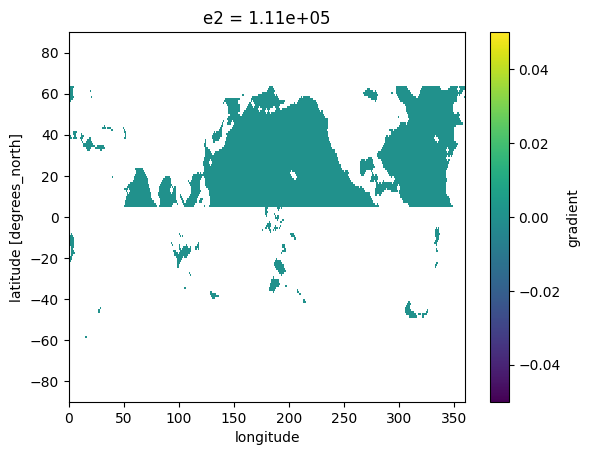

In [41]:
ds["gradient"].plot(robust=True, x="lon", y="lat")


Step 0, Loss: 2.769012212753296


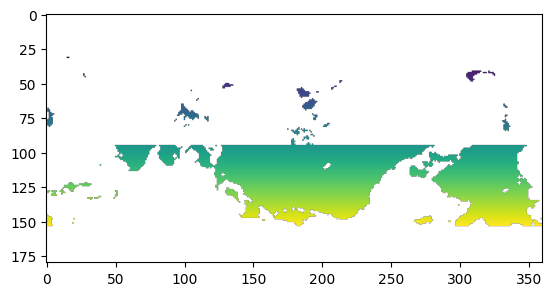

Step 100, Loss: nan


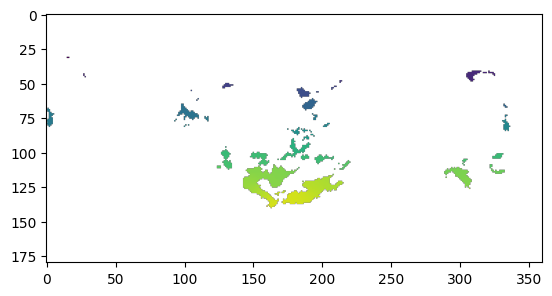

Step 200, Loss: nan


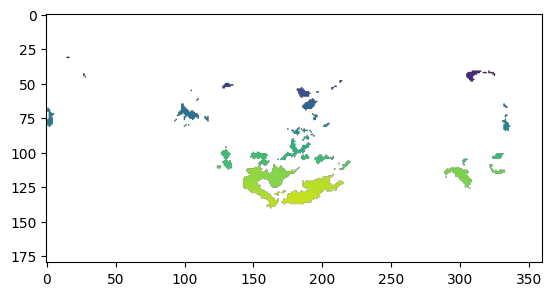

In [ ]:
   
# Run optimization
optimal_surface, loss_history = train(
    initial_surface, 
    learning_rate=.1, 
    num_steps=2000
)

print("Optimization complete!")
print(f"Initial loss: {floss(initial_surface)}")
print(f"Final loss: {floss(optimal_surface)}")

In [ ]:
xr.DataArray(initial_surface- optimal_surface).plot(robust=True)

In [ ]:
plt.imshow(initial_surface- optimal_surface)